# Importing Libraries/Reading in Data

In [238]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

In [239]:
df = pd.read_csv('Data/Prem-Tomorrowland_posts_11-16.csv')
df.head()

,title,selftext,subreddit,created_utc
0,Genreverse,"Hi everyone, \n\nHere at Genreverse our ultima...",Tomorrowland,1637031457
1,Tomorrowland and it's bass line-up,So obviously Tomorrowland has always had a gre...,Tomorrowland,1637002849
2,Hand crafts 2021,NaN,Tomorrowland,1636935255
3,Winter TML lodging,hello! I have the 4 day pass without lodging a...,Tomorrowland,1636922669
4,Was Tomorrowland around the world 2020 a speci...,NaN,Tomorrowland,1636904090


In [240]:
df.shape

(2000, 4)

---

# Cleaning/Preprocessing/EDA

### Cleaning/Creating Length Columns

In [241]:
df.isnull().sum()

title            0
selftext       885
subreddit        0
created_utc      0
dtype: int64

In [242]:
df[(df['selftext'].isnull()) & (df['subreddit'] == 'Tomorrowland')].shape
# almost even split of null values in selftext column between Tomorrowland and Premier League Reddits

(451, 4)

In [243]:
df[df['selftext'] == '']

,title,selftext,subreddit,created_utc


In [244]:
df['selftext'].fillna('', inplace=True)  # good imputation or no? (almost even split of nulls)

In [245]:
length = []
for i in df['title']:
    length.append(len(i))
    
df['title_length'] = length

In [246]:
num_words = []
for i in df['title']:
    num_words.append(len(i.split()))

df['title_word_count'] = num_words

In [247]:
length = []
for i in df['selftext']:
    length.append(len(i))
    
df['selftext_length'] = length

In [248]:
num_words = []
for i in df['selftext']:
    num_words.append(len(i.split()))

df['selftext_word_count'] = num_words

In [249]:
df.head()

,title,selftext,subreddit,created_utc,title_length,title_word_count,selftext_length,selftext_word_count
0,Genreverse,"Hi everyone, \n\nHere at Genreverse our ultima...",Tomorrowland,1637031457,10,1,398,57
1,Tomorrowland and it's bass line-up,So obviously Tomorrowland has always had a gre...,Tomorrowland,1637002849,34,5,620,104
2,Hand crafts 2021,,Tomorrowland,1636935255,16,3,0,0
3,Winter TML lodging,hello! I have the 4 day pass without lodging a...,Tomorrowland,1636922669,18,3,334,65
4,Was Tomorrowland around the world 2020 a speci...,,Tomorrowland,1636904090,60,9,0,0


In [250]:
df.groupby('subreddit').mean()[['title_length', 'title_word_count', 'selftext_length', 'selftext_word_count']]

,title_length,title_word_count,selftext_length,selftext_word_count
subreddit,,,,
PremierLeague,61.019,10.807,182.256,28.285
Tomorrowland,47.623,8.171,196.799,33.495


**Premier Leauge posts tend to have longer titles and shorter entries than Tomorrowland posts**

---

# Models

### Model Preparation

In [251]:
df['subreddit'] = df['subreddit'].map({'Tomorrowland': 0, 'PremierLeague': 1})
# target column created

In [252]:
X = df['title']
y = df['subreddit']

In [253]:
y.value_counts(normalize=True)
# baseline accuracy of 50% if predicting subreddit is from Premier League subreddit <- looking to beat this

0    0.5
1    0.5
Name: subreddit, dtype: float64

In [254]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

---

### Model 1 - KNN with CountVectorizer

In [255]:
pipe1 = Pipeline([
    ('cvec', CountVectorizer()),
    ('knn', KNeighborsClassifier())
])

In [256]:
params1 = {
    'cvec__min_df': [8, 9, 10],
    'cvec__max_df': [.1, .2, .3],
    'cvec__binary': [True, False],
    'cvec__stop_words': [None, 'english'],
    'knn__weights': ['uniform', 'distance']
}

In [257]:
gs1 = GridSearchCV(pipe1, param_grid=params1)
gs1.fit(X_train, y_train)
print(gs1.best_score_)
gs1.best_params_

0.834


{'cvec__binary': False,
 'cvec__max_df': 0.2,
 'cvec__min_df': 9,
 'cvec__stop_words': 'english',
 'knn__weights': 'distance'}

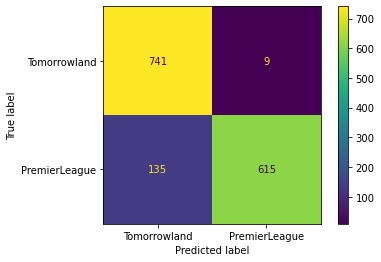

In [258]:
plot_confusion_matrix(gs1, X_train, y_train, display_labels=['Tomorrowland', 'PremierLeague'])

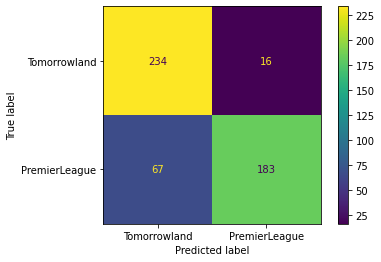

In [259]:
plot_confusion_matrix(gs1, X_test, y_test, display_labels=['Tomorrowland', 'PremierLeague'])

In [260]:
preds1 = gs1.predict(X_test)
X_test[(y_test != preds1) & (preds1 == 1)].head(8)

821    I really hope Martin Garrix features whoever m...
504                            Good luck getting refunds
240                                 Can i still buy tix?
270                                     Change time zone
560    Buy Xanax Online without Prescription for Anxi...
805    The best time of my life deserves to be on my ...
492                          Time to make legal steps...
267    One of the best ways to watch: with Philips Hu...
Name: title, dtype: object

---

### Model 2 - KNN with TFIDF

In [261]:
pipe2 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('knn', KNeighborsClassifier())
])

In [262]:
params2 = {
    'knn__n_neighbors': [6, 7, 8],
    'tvec__stop_words': ['english', None],
    'tvec__min_df': [8, 9, 10, 11, 12],
    'tvec__max_df': [.1, .2, .3, .4],
    'tvec__ngram_range': [(1,1), (1,2)]
}

In [263]:
gs2 = GridSearchCV(pipe2, param_grid=params2)
gs2.fit(X_train, y_train)
print(gs2.best_score_)
gs2.best_params_

0.8460000000000001


{'knn__n_neighbors': 7,
 'tvec__max_df': 0.2,
 'tvec__min_df': 10,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': 'english'}

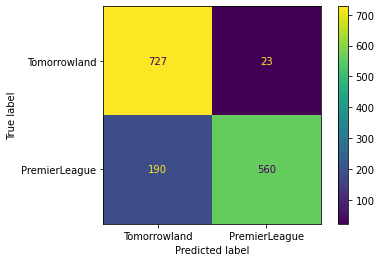

In [264]:
plot_confusion_matrix(gs2, X_train, y_train, display_labels=['Tomorrowland', 'PremierLeague'])

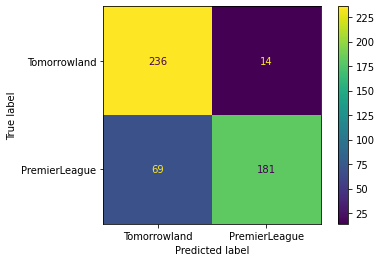

In [265]:
plot_confusion_matrix(gs2, X_test, y_test, display_labels=['Tomorrowland', 'PremierLeague'])

---

### Model 3 - Logistic Regression and CountVectorizer

In [266]:
pipe3 = Pipeline([
    ('cvec', CountVectorizer()),
    ('logreg', LogisticRegression())
])

In [267]:
params3 = {
    'cvec__min_df': [2, 3, 4, 5, 6],
    'cvec__max_df': [.1, .2, .3],
    'cvec__binary': [True, False],
    'cvec__stop_words': [None, 'english'],
    'cvec__ngram_range': [(1,1), (1,2)]
}

In [268]:
gs3 = GridSearchCV(pipe3, param_grid=params3)
gs3.fit(X_train, y_train)
print(gs3.best_score_)
gs3.best_params_

0.8973333333333333


{'cvec__binary': False,
 'cvec__max_df': 0.2,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': 'english'}

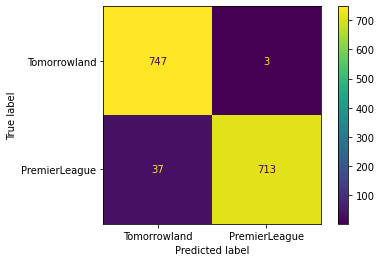

In [269]:
plot_confusion_matrix(gs3, X_train, y_train, display_labels=['Tomorrowland', 'PremierLeague'])

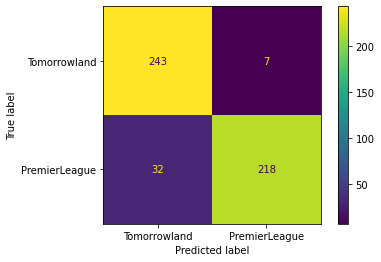

In [270]:
plot_confusion_matrix(gs3, X_test, y_test, display_labels=['Tomorrowland', 'PremierLeague'])

---

### Model 4 - Logistic Regression and TFIDF

In [271]:
pipe4 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logreg', LogisticRegression())
])

In [272]:
params4 = {
    'tvec__stop_words': [None, 'english'],
    'tvec__min_df': [1, 2, 3, 4, 5],
    'tvec__max_df': [.2, .3, .4],
    'tvec__ngram_range': [(1,1), (1,2)]
}

In [273]:
gs4 = GridSearchCV(pipe4, param_grid=params4)
gs4.fit(X_train, y_train)
print(gs4.best_score_)
gs4.best_params_

0.9113333333333333


{'tvec__max_df': 0.2,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': 'english'}

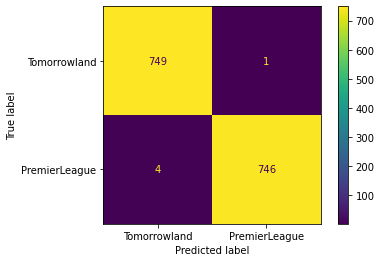

In [274]:
plot_confusion_matrix(gs4, X_train, y_train, display_labels=['Tomorrowland', 'PremierLeague'])

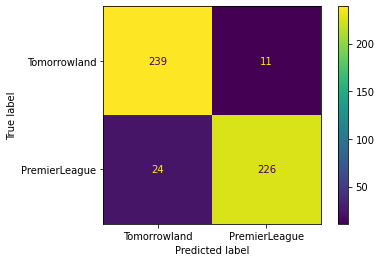

In [275]:
plot_confusion_matrix(gs4, X_test, y_test, display_labels=['Tomorrowland', 'PremierLeague'])

---

### Model 5 - Decision Tree and CountVectorizer